In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import YouTubeVideo

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Bayesian Inference with Sampling

## Approximating a Known Distribution with Samples

We've seen before that we can compute an empirical distribution from a sample of data points. In this section, we'll use samples to approximate distributions.

Let's start by using samples to approximate a known, easy-to-compute distribution: Beta$(3, 4)$. While this is a somewhat silly example because the distribution is easy to reason about, it will help us see how samples can provide a useful approximation to a distribution.

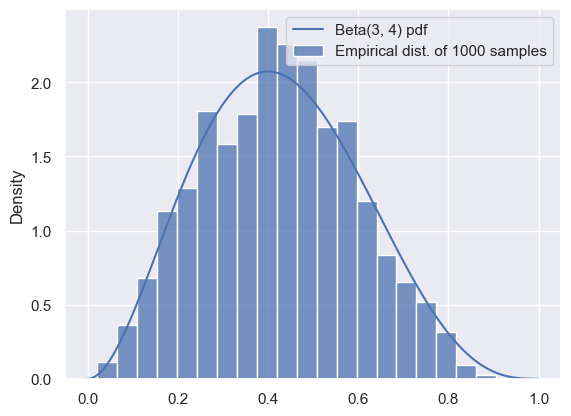

In [51]:

from scipy import stats

distribution = stats.beta(3, 4)
num_samples = 1000

# Compute the exact PDF:
t = np.linspace(0, 1, 500)
pdf = distribution.pdf(t)

# Draw 1000 samples, and look at the empirical distribution of those samples:
samples = distribution.rvs(num_samples)
f, ax = plt.subplots(1, 1)

sns.histplot(
    x=samples, stat='density', bins=20, 
    label=f'Empirical dist. of {num_samples} samples'
)
ax.plot(t, pdf, label='Beta(3, 4) pdf')
ax.legend()

We can see that the samples are a good representation for the distribution, as long as we have enough. We can use the mean of the samples to approximate the mean of the distribution:

In [6]:
# The mean of a Beta(a, b) distribution is a/(a+b):
true_mean = 3 / (3 + 4)

approx_mean = np.mean(samples)
print(true_mean, approx_mean)

0.42857142857142855 0.4236414308526358


Similarly, we could use the variance of the samples to estimate the variance of the distribution, and so on.

While this method was extremely easy to implement, it's also somewhat silly: for this distribution, anything that we can do with samples can also be done analytically. Usually, we want to approximate difficult, intractable distributions that involve impossible-to-compute normalization constants. So, that's what we'll do next.

## Rejection Sampling

Rejection sampling works by generating a large number of proposals, and then rejecting those that are unlikely or impossible.

As a warm-up, let's suppose that we want to sample a pair of random variables ($x_1$, $x_2$) drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below:

How can we go about doing this? 

*(Hint: first sample uniformly over the unit square.)*

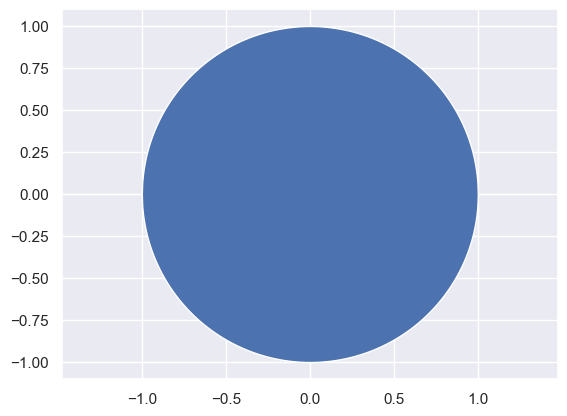

In [7]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.fill_between(x_, -semicircle, semicircle)
plt.axis('equal');

Variance of x1 (estimated from samples): 0.243


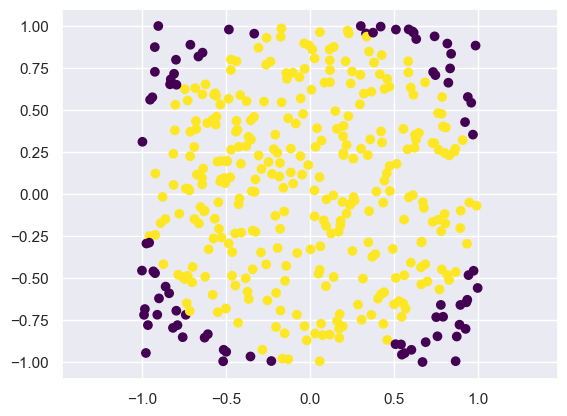

In [8]:

# Number of samples
N = 400

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=is_in_circle, cmap='viridis')
plt.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

In [9]:
YouTubeVideo('Nbszb5tGmFo')

Next, let's think about sampling from a distribution with a complicated density. Suppose we want to sample from the distribution with density $p(\theta|x) \propto \theta \cdot (1.5-\theta) \cdot \sin(\theta)$ for $\theta \in [0,1.5]$:

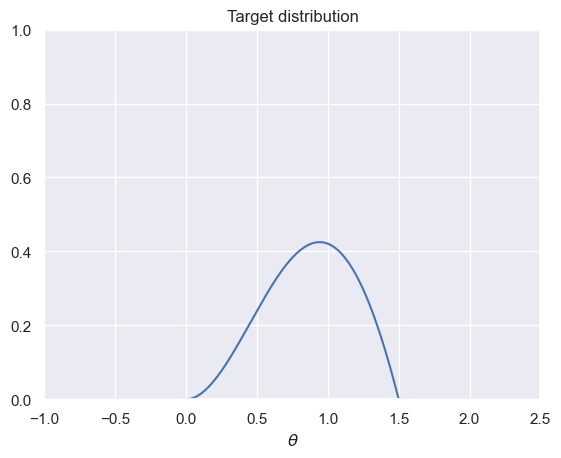

In [10]:
t = np.linspace(-1, 2.5, 500)
def target(t):
    """The unnormalized distribution we want to sample from"""
    return t * (1.5-t) * np.sin(t) * ((t > 0) & (t < 1.5))
plt.plot(t, target(t))
plt.title('Target distribution')
plt.xlabel(r'$\theta$')
plt.axis([-1,2.5,0,1])
plt.show()

How can we make this look like the geometry-based example from before? The solution is an algorithm called **rejection sampling**. There are two ways of understanding how it works:

The first is to start by generating samples from a uniform distribution. We'll then throw some away at random (instead of deterministically like in the previous example). Intuitively, looking at the diagram below that compares our target to the Uniform$(0, 1.5)$ distribution, we should try to throw away more samples for very small values of $\theta$, and we should try to keep more samples between $0.5$ and 1. In other words, our probability of rejecting each sample should depend on how likely it is according to the target.

The second is to change our one-dimensional sampling problem (i.e., generate samples for $\theta$) two a two-dimensional sampling problem, where we sample from the orange box in the graph below, and then throw away samples that don't fall under the blue curve. In order to  do this, we must first sample $\theta$ values, and then sample heights for each one. If the height is too large (falls above the corresponding target height for that value of $\theta$, then we will reject the sample.


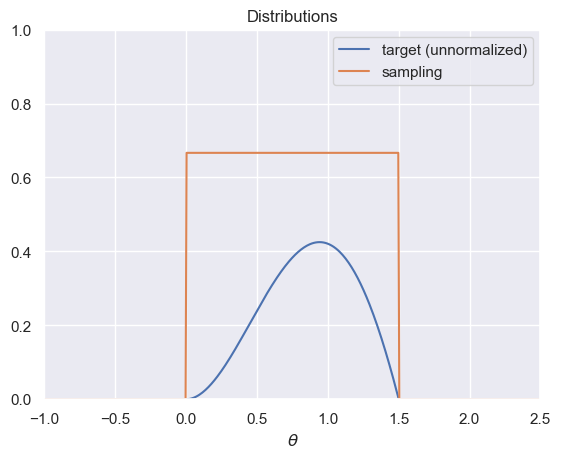

In [11]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(t):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(t, 0, 1.5)

plt.plot(t, target(t), label='target (unnormalized)')
plt.plot(t, uniform_sampling_dist(t), label='sampling')
plt.axis([-1,2.5,0,1])
plt.legend()
plt.title('Distributions')
plt.xlabel(r'$\theta$')
plt.show()


To be more precise, rejection sampling works as follows: given an unnormalized target distribution and proposal distribution, we generate samples from the normalized version of the target distribution by:

1. Generate samples from the proposal distribution.
2. For each generated sample from the previous step, compute the ratio of the target divided by the proposal. This represents the probability that we'll accept the sample: larger values of the target will lead to higher acceptance probability, and smaller values of the target will lead to lower acceptance probability. In order for this ratio to be treated as a probability, we require that the target always be less than (or equal to) the proposal: this can always be achieved through a good choice of proposal and appropriate scaling of the target distribution.
3. Randomly accept or reject each sample from step 1, with probability determined by its ratio from step 2. This can be done by generating a Uniform$(0, 1)$ random variable for each sample, and accepting the sample that random variable is less than the acceptance probability. **Stop and convince yourself that this is true before continuing!** Discard all rejected samples.
4. The accepted samples will be true samples from the normalized density corresponding to the unnormalized target.

The following code implements rejection sampling. Note that there are only four (substantive) lines of code in this function, corresponding to the four steps above: 

In [12]:
def rejection_sample_uniform(num_proposals=100):
    # Generate proposals for samples: these are θ-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_proposals)
    
    # Acceptance probability is the ratio of the two curves
    # These had better all be between 0 and 1!
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_proposals) < accept_probs
    
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_proposals))
    return proposals[accept]


Let's apply it to our target distribution from above:

Max accept prob: 0.638
Accepted 169 out of 500 proposals
Max accept prob: 0.638
Accepted 3506 out of 10000 proposals


(-0.25, 1.75, 0.0, 1.8)

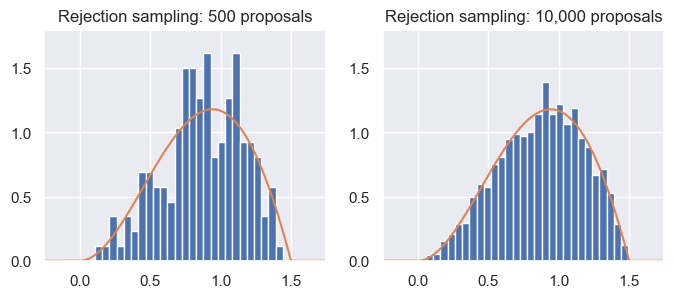

In [38]:
f, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

# Run rejection sampling twice, once with many proposals and once with few proposals
samples_sparse = rejection_sample_uniform(num_proposals=500)
samples_dense = rejection_sample_uniform(num_proposals=10000)

# Plot a true histogram (comparable with density functions) using density=True
axs[0].hist(samples_sparse, bins=np.linspace(-0.25, 1.75, 40), density=True)
axs[1].hist(samples_dense, bins=np.linspace(-0.25, 1.75, 40), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
axs[0].plot(t, target(t) / 0.36)
axs[1].plot(t, target(t) / 0.36)

axs[0].set_title('Rejection sampling: 500 proposals')
axs[1].set_title('Rejection sampling: 10,000 proposals')
axs[0].axis([-0.25, 1.75, 0, 1.8])
axs[1].axis([-0.25, 1.75, 0, 1.8])


From the results, we can see that rejection sampling, when run with enough proposals, correctly and accurately gives us samples from the target distribution. But, it can be **inefficient**: we accepted less than half of the samples each time! Indeed, even with 10,000 proposals (right), the samples don't perfectly represent the target distribution.

This problem of inefficiency is caused by rejecting samples. Note that the maximum acceptance probability was only around 0.64. If we were to scale the proposal distribution by a factor of $1/0.64 \approx 1.56$, then we'd reject fewer samples overall, while still ensuring that the probabilities never went above 1.

Unfortunately, the inefficiency problem starts to get much worse when working in high dimensions! When dealing with high-dimensional distributions, there is often much more of the space with relatively low density, which means many more samples being rejected.

As a second example, what happens if we want to sample from a target distribution that takes on values in $[0, \infty)$? For instance, suppose our density is $p(\theta|x) \propto \exp(-\theta) |\sin(2\theta)|$ for $\theta \in [0, \infty)$. We can't use a Uniform$(a, b)$ proposal distribution. Why not? For any value of $b$, we'll never generate a sample greater than $b$, so our samples won't match the true distribution. 

Instead, we could use the normal or exponential distribution:

In [50]:
1/0.64

1.5625

Accepted 615 out of 1000 proposals


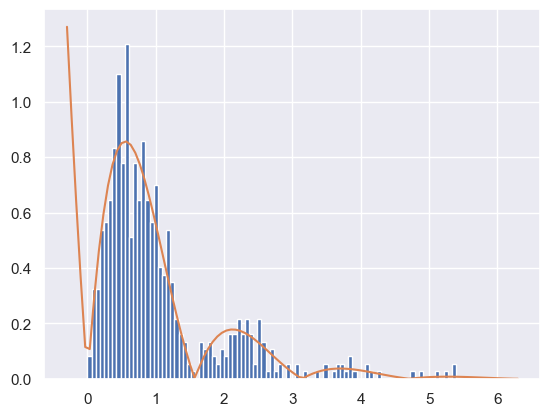

In [47]:
def decaying_target_distribution(t):
    """Unnormalized target distribution as described above"""
    return np.exp(-t) * np.abs(np.sin(2*t))

def sampling_distribution_exponential(t):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of θ=0
    return stats.expon.pdf(t, loc=0, scale=1.0)

def rejection_sample_exponential(num_proposals=500):
    """Rejection sampling with an exponential distribution with λ=1"""
    proposals = np.random.exponential(scale=1.0, size=num_proposals)
    accept_probs = decaying_target_distribution(proposals) / sampling_distribution_exponential(proposals)
    accept = np.random.uniform(0, 1, num_proposals) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_proposals))
    return proposals[accept]

samples = rejection_sample_exponential(num_proposals=1000)
plt.hist(samples, bins=np.linspace(0, 6, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

tmin, tmax, _, _ = plt.axis()
t_inf = np.linspace(tmin, tmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
plt.plot(t_inf, decaying_target_distribution(t_inf) / 0.6)
plt.show()

To summarize, we saw that rejection sampling can be used to draw samples given only an unnormalized target distribution. Even though it can be used to draw samples from any unnormalized target, we most often will use it (and other sampling methods) with the  unnormalized target distribution being the numerator of a posterior distribution $p(\theta|x)p(\theta)$.

Rejection sampling works by using a proposal distribution that's easy to sample from: while the normal and uniform distributions are most common, we can use any distribution as long as (a) we can draw samples from it and (b) we can guarantee that it will always be greater than (or equal to) a scaled version of our target distribution. It works by (1) generating proposals from the proposal distribution, (2) computing the ratio of target divided by proposal as the acceptance probability, and (3) accepting each sample with its acceptance probability. It's typically inefficient, especially in high dimensions.

In [15]:
YouTubeVideo('S9korbhU4Wg')

## Markov Chain Monte Carlo

We noticed that the inefficiency of rejection sampling was due to the large number of proposals that we rejected and discarded. Indeed, rejection sampling generates each sample independently, without using any information from previously generated samples about which areas have lower and higher probability.

**Markov chain Monte Carlo (MCMC)** methods take a different approach by generating a sequence of samples. Each sample depends on the previous one, which lets us generate better samples. We'll construct the sequence of samples in such a way that they form a Markov chain whose steady state distribution is the true normalized version of the target distribution.

### Markov Chains

*You may find it helpful to see the same material presented in an expanded format in [Chapter __ of the Data 140 textbook]().*

*Coming soon*

### Metropolis-Hastings (Optional)

*Coming soon*

### Gibbs sampling

Gibbs sampling is an algorithm designed to work with high-dimensional posterior distributions. It works by iteratively resampling each individual variable conditioned on the data and all other random variables.




Note that even though we made reference to posterior distributions and conditioning on data throughout this section, Gibbs sampling is a general method that can be used to sample from any high-dimensional target where the conditional distributions $p(\theta_i 

## Implementing models in PyMC

*This section is under development and is subject to change substantially in the next week.*

We spent a lot of time doing algebra to derive the posterior distributions and estimates for the review model. At this point, you might be asking: couldn't we do a lot of that work computationally? It turns out the answer is yes! PyMC is a Python library for Bayesian inference. In order to use it, you must specify a probabilistic model (like the three we've just seen) and observed data, and it will compute the posterior distribution over all unknown variables. 

Let's try it out on the product review model:

$$
\begin{align}
    x_i | \theta  &\sim \mathrm{Bernoulli}(\theta) \\
    \theta &\sim \mathrm{Beta}(\alpha, \beta)
\end{align}
$$

We'll start by specifying our data: Microwave A has 3 positive reviews and 0 negative reviews, and Microwave B has 19 positive reviews and 1 negative review.

In [16]:
reviews_a = np.array([1, 1, 1])
reviews_b = np.append(np.ones(19), np.zeros(1))

Then, we'll define the model: carefully review the code below, making sure you understand the logic behind each line (except the very last one):

In [17]:
import pymc as pm
import arviz as az

# Parameters of the prior
alpha = 1
beta = 5

with pm.Model() as model:
    # Define a Beta-distributed random variable called theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta)
    
    # Defines a Bernoulli RV called x. Since x is observed, we
    # pass in the observed= argument to provide our data
    x = pm.Bernoulli('x', p=theta, observed=reviews_b)
    
    # This line asks PyMC to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace = pm.sample(2000, chains=2, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [18]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [19]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    theta    (chain, draw) float64 0.9094 0.8279 0.8491 ... 0.7912 0.8393 0.8404
Attributes:
    created_at:                 2025-02-07T03:50:51.333066+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.17.0
    sampling_time:              0.7237918376922607
    tuning_steps:               1000

(array([  7.,  30.,  92., 267., 462., 794., 990., 870., 397.,  91.]),
 array([0.45901955, 0.50886517, 0.5587108 , 0.60855643, 0.65840206,
        0.70824768, 0.75809331, 0.80793894, 0.85778457, 0.9076302 ,
        0.95747582]),
 <BarContainer object of 10 artists>)

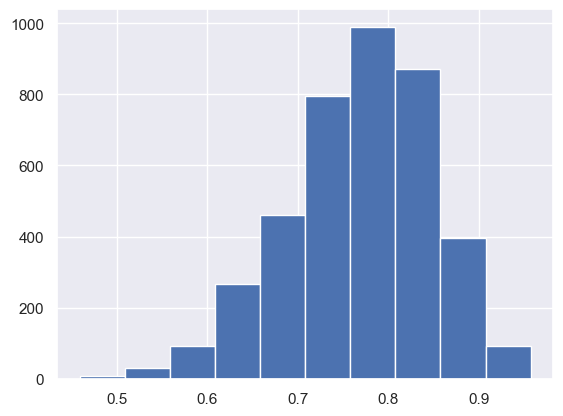

In [20]:
plt.hist(trace.posterior['theta'].values.flatten())

#### Exoplanet model in PyMC

In [21]:
planets = pd.read_csv('exoplanets.csv')
planets.shape

(517, 6)

Let's try a more interesting model: our mixture model for exoplanets:

$$
\begin{align}
    z_i &\sim \mathrm{Bernoulli}(\pi) & i = 1, \ldots, n \\
    \mu_k &\sim \mathcal{N}(\mu_p, \sigma_p) &  k =0, 1 \\
    x_i | z_i, \mu_0, \mu_1 &\sim \mathcal{N}(\mu_{z_i}, \sigma) & i = 1, \ldots, n\\
\end{align}
$$

First, we'll need a trick called "fancy indexing". Here's how it works:

In [22]:
example_zs = np.array([1, 0, 0, 1, 1, 0])
example_mus = np.array([1.3, 10.2])

means = example_mus[example_zs]
means

array([10.2,  1.3,  1.3, 10.2, 10.2,  1.3])

In [23]:
pi = 0.6      # Prior probability of a planet being in the large/uninhabitable group
sigma = 1.5   # SD of likelihood
mu_p = 5      # Mean of prior
sigma_p = 10  # Variance of prior: important to choose a large value here

with pm.Model() as model_exoplanet:
    
    # This defines a Bernoulli random variable called 'z' in our model.
    z = pm.Bernoulli('z', p=pi)
    
    # This creates an array of two random variables called 'mu'
    # (one for each group), because we used the shape=2 argument
    mu = pm.Normal('mu', mu=mu_p, sigma=sigma_p, shape=2)

    planet_means = mu[z]
    # this is the tricky bit with the indexing: we'll use the "fancy indexing" idea
    # from above
    x = pm.Normal('x', mu=planet_means, sigma=sigma, observed=planets['radius'])
    
    trace_exoplanet = pm.sample(2000, chains=2, tune=1000, return_inferencedata=True)
    
    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [mu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
/Users/ramesh/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
trace_exoplanet.posterior['mu'].values

array([[[5.7606534 , 9.74250247],
        [5.7606534 , 9.74250247],
        [5.7606534 , 9.74250247],
        ...,
        [5.7606534 , 9.74250247],
        [5.7606534 , 9.74250247],
        [5.7606534 , 9.74250247]],

       [[9.9878681 , 9.90602881],
        [9.9878681 , 9.90602881],
        [9.9878681 , 9.90602881],
        ...,
        [9.9878681 , 9.90602881],
        [9.9878681 , 9.90602881],
        [9.9878681 , 9.90602881]]])